# PBO learnt on several iterations and one weigth one the car on hill environment

## Define parameters

In [24]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp

# keys
seed = 0
key = jax.random.PRNGKey(seed)
sample_key, shuffle_key, q_network_key, random_weights_key, pbo_network_key = jax.random.split(key, 5)


# Sample collection
n_states_x = 10
n_states_v = 10
n_actions = 2
n_uniform_samples = 200
n_samples = n_states_x * n_states_v * n_actions * n_uniform_samples
gamma = 0.9

# # Weights collection
n_weights = 100

# # Trainings
layers_dimension = (10,)
max_bellman_iterations = 5
batch_size_samples = n_samples

# ## Linear PBO
training_steps = 100
fitting_steps = 5
batch_size_weights = n_weights
learning_rate = {"first": 0.001, "last": 0.00005, "duration": training_steps * fitting_steps * n_samples // batch_size_samples}

# ## Q-learning
fitting_steps_q = fitting_steps * training_steps
learning_rate_q = {"first": 0.01, "last": 0.005, "duration": fitting_steps_q * n_samples // batch_size_samples}

# # Visualisation of errors and performances
horizon = 70

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define environment

In [2]:
from pbo.environment.car_on_hill import CarOnHillEnv

max_pos = 1.0
max_velocity = 3.0

states_x = jnp.linspace(-max_pos, max_pos, n_states_x)
boxes_x_size = (2 * max_pos) / (n_states_x - 1)
states_x_boxes = (np.linspace(-max_pos, max_pos + boxes_x_size, n_states_x + 1) - boxes_x_size / 2)
states_v = jnp.linspace(-max_velocity, max_velocity, n_states_v)
boxes_v_size = (2 * max_velocity) / (n_states_v - 1)
states_v_boxes = (np.linspace(-max_velocity, max_velocity + boxes_v_size, n_states_v + 1) - boxes_v_size / 2)


env = CarOnHillEnv(max_pos, max_velocity, gamma)

## Collect samples

### Samples on the mesh and with a uniform policy

In [27]:
from pbo.sample_collection.replay_buffer import ReplayBuffer


replay_buffer = ReplayBuffer()

n_samples = n_states_x * n_states_v * n_actions

for state_x in states_x:
    for state_v in states_v:
        state = jnp.array([state_x, state_v])
        
        for action in jnp.arange(n_actions):
            env.reset(state)
            next_state, reward, _, _ = env.step(jnp.array([action]))

            replay_buffer.add(state, jnp.array([action]), reward, next_state)

env.reset()
for idx_sample in range(n_uniform_samples):
    sample_key, key = jax.random.split(sample_key)
    if jax.random.uniform(key) > 0.5:
        action = jnp.array([0])
    else:
        action = jnp.array([1])
    next_state, reward, absording, _ = env.step(action)

    replay_buffer.add(env.state, action, reward, next_state)

    if absording:
        env.reset()

replay_buffer.cast_to_jax_array()

### Visualize samples

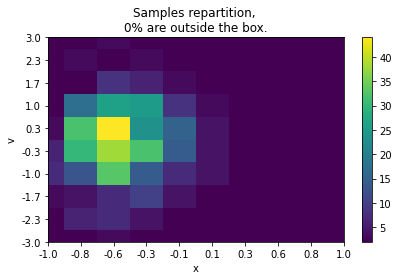

In [28]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.two_dimesions_mesh import TwoDimesionsMesh


samples_count, n_outside_boxes = count_samples(replay_buffer.states[:, 0], replay_buffer.states[:, 1], states_x_boxes, states_v_boxes)
samples_visu_mesh = TwoDimesionsMesh(states_x, states_v, sleeping_time=0, axis_equal=False)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box.", xlabel="x", ylabel="v"
)

## Optimal Q function

  0%|          | 0/80 [00:00<?, ?it/s]

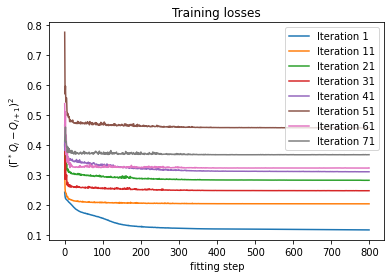

In [5]:
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.networks.learnable_q import FullyConnectedQ


max_bellman_iterations_optimal = 80
fitting_steps_q_optimal = 800

data_loader_samples = SampleDataLoader(replay_buffer, n_samples, shuffle_key)
q_optimal = FullyConnectedQ(
    state_dim=2,
    action_dim=1,
    continuous_actions=False,
    n_actions_on_max=n_actions,
    action_range_on_max=None,
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    learning_rate={"first": 0.01, "last": 0.0005, "duration": fitting_steps_q_optimal},
    layers_dimension=layers_dimension,
    zero_initializer=True,
)

l2_losses = np.ones((max_bellman_iterations_optimal, fitting_steps_q_optimal)) * np.nan

for bellman_iteration in tqdm(range(max_bellman_iterations_optimal)):
    params_target = q_optimal.params
    q_optimal.reset_optimizer()

    for step in range(fitting_steps_q_optimal):
        cumulative_l2_loss = 0
        
        data_loader_samples.shuffle()
        for batch_samples in data_loader_samples:
            q_optimal.params, q_optimal.optimizer_state, l2_loss = q_optimal.learn_on_batch(q_optimal.params, params_target, q_optimal.optimizer_state, batch_samples)
            cumulative_l2_loss += l2_loss

        l2_losses[bellman_iteration, step] = cumulative_l2_loss


for bellman_iteration in range(0, max_bellman_iterations_optimal, 10):
    plt.plot(l2_losses[bellman_iteration], label=f"Iteration {bellman_iteration + 1}")

plt.legend()
plt.xlabel("fitting step")
plt.ylabel(r"$(\Gamma^*Q_i - Q_{i +  1})^2$")
plt.title("Training losses")
plt.show()

In [6]:
env.simulate(q_optimal, horizon, jnp.array([-0.5, 0]))

[-0.5  0. ]
[0.14574909]
[0.07916451]

[-0.5196691 -0.3866922]
[0.28718567]
[0.13193417]

[-0.57458174 -0.69058496]
[0.37403107]
[0.15771961]

[-0.6524237  -0.83584255]
[0.44891167]
[0.2568674]

[-0.73584473 -0.8066418 ]
[0.5384903]
[0.46590614]

[-0.80970716 -0.6561602 ]
[0.65133095]
[0.6975241]

[-0.8379713   0.08472195]
[1.1751661]
[1.4421768]

[-0.79239184  0.83640504]
[1.6387291]
[2.1696672]

[-0.6681012  1.6570239]
[1.5453362]
[2.4723535]

[-0.46682808  2.2751522 ]
[0.3974409]
[2.0570374]

[-0.24085198  2.121697  ]
[1.3503857]
[3.8410726]

[-0.05408749  1.6044002 ]
[2.1842976]
[4.0276837]

[0.08628011 1.2741613 ]
[1.8574238]
[4.7152777]

[0.2062369 1.1392648]
[2.1791286]
[7.1913586]

[0.31660053 1.0807475 ]
[3.8138838]
[9.357697]

[0.425263 1.10823 ]
[7.8691177]
[10.649012]

[0.5414516 1.2311448]
[10.6478405]
[11.789333]

[0.6743681 1.4400225]
[12.193687]
[13.029063]

[0.8316725 1.7153956]
[12.795765]
[14.117152]



DeviceArray([ True], dtype=bool)

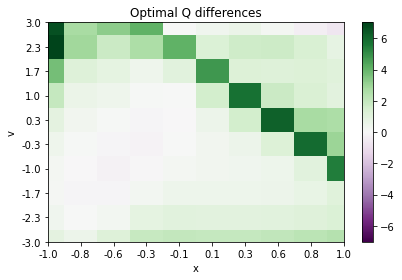

In [7]:
optimal_diff_q = env.diff_q_mesh(q_optimal, states_x, states_v)

q_visu_mesh = TwoDimesionsMesh(states_x, states_v, sleeping_time=0, axis_equal=False, zero_centered=True)

q_visu_mesh.set_values(optimal_diff_q)
q_visu_mesh.show("Optimal Q differences", xlabel="x", ylabel="v")

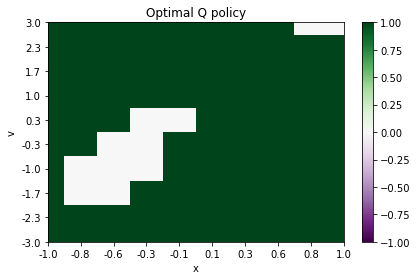

In [8]:
q_visu_mesh.set_values((optimal_diff_q > 0).astype(float))
q_visu_mesh.show("Optimal Q policy", xlabel="x", ylabel="v")

## Train Q with Fitted-Q

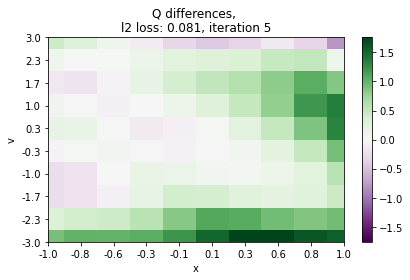

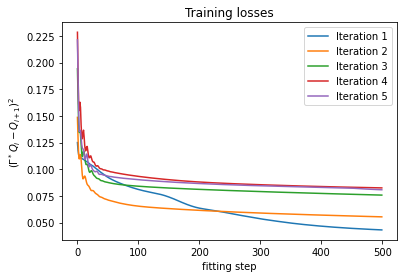

In [9]:
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.networks.learnable_q import FullyConnectedQ


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
q = FullyConnectedQ(
    state_dim=2,
    action_dim=1,
    continuous_actions=False,
    n_actions_on_max=n_actions,
    action_range_on_max=None,
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    learning_rate=learning_rate_q,
    layers_dimension=layers_dimension,
    zero_initializer=True,
)

l2_losses = np.zeros((max_bellman_iterations, fitting_steps_q))

for bellman_iteration in range(max_bellman_iterations):
    params_target = q.params

    for step in range(fitting_steps_q):
        cumulative_l2_loss = 0
        
        data_loader_samples.shuffle()
        for batch_samples in data_loader_samples:
            q.params, q.optimizer_state, l2_loss = q.learn_on_batch(q.params, params_target, q.optimizer_state, batch_samples)
            cumulative_l2_loss += l2_loss

        l2_losses[bellman_iteration, step] = cumulative_l2_loss

    diff_q = env.diff_q_mesh(q, states_x, states_v)

    q_visu_mesh.set_values(diff_q)
    q_visu_mesh.show(f"Q differences, \nl2 loss: {str(jnp.round(cumulative_l2_loss, 3))}, iteration {bellman_iteration + 1}", xlabel="x", ylabel="v")



for bellman_iteration in range(max_bellman_iterations):
    plt.plot(l2_losses[bellman_iteration], label=f"Iteration {bellman_iteration + 1}")

plt.legend()
plt.xlabel("fitting step")
plt.ylabel(r"$(\Gamma^*Q_i - Q_{i +  1})^2$")
plt.title("Training losses")
plt.show()

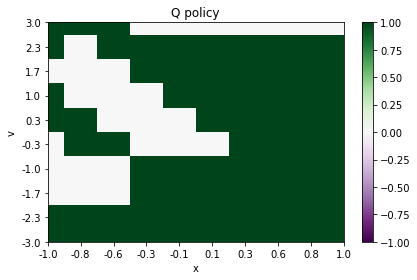

In [10]:
diff_q = env.diff_q_mesh(q, states_x, states_v)

q_visu_mesh.set_values((diff_q > 0).astype(float))
q_visu_mesh.show("Q policy", xlabel="x", ylabel="v")

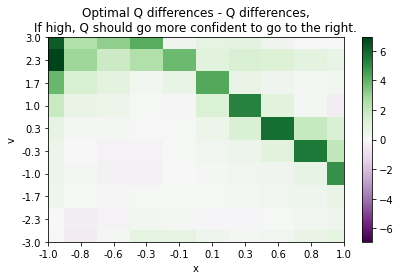

In [11]:
q_visu_mesh.set_values(optimal_diff_q - diff_q)
q_visu_mesh.show(f"Optimal Q differences - Q differences,\nIf high, Q should go more confident to go to the right.", xlabel="x", ylabel="v")

In [12]:
env.simulate(q, horizon, jnp.array([-0.5, 0]))

[-0.5  0. ]
[0.36572057]
[0.35640174]

[-0.5196691 -0.3866922]
[0.30050665]
[0.3679468]

[-0.5355568   0.07360952]
[0.38094777]
[0.3836828]

[-0.5053787  0.5206502]
[0.3123265]
[0.23329002]

[-0.47415787  0.09371723]
[0.35203284]
[0.306516]

[-0.4872082 -0.3507429]
[0.31387]
[0.36633414]

[-0.50271744  0.04574394]
[0.36838275]
[0.35195476]

[-0.51769924 -0.3402948 ]
[0.31229073]
[0.3739547]

[-0.52928126  0.11211871]
[0.38112396]
[0.37194246]

[-0.5352233  -0.22884539]
[0.33407778]
[0.3882094]

[-0.5344211   0.24466373]
[0.3844884]
[0.3560992]

[-0.5270286  -0.09943872]
[0.35963517]
[0.3881889]

[-0.51442367  0.34771731]
[0.35823137]
[0.3004442]

[-0.4990467  -0.04534642]
[0.36260813]
[0.36179525]

[-0.5231919  -0.42928585]
[0.2889126]
[0.3607009]

[-0.54287356  0.04130004]
[0.3794257]
[0.39366227]

[-0.5151656  0.5046774]
[0.3302284]
[0.25708884]

[-0.484523  0.09796 ]
[0.35836965]
[0.319094]

[-0.4961961 -0.327719 ]
[0.3183654]
[0.37040704]

[-0.50860053  0.08367193]
[0.37159246]
[0.

DeviceArray([False], dtype=bool)

## Collect weights

In [13]:
from pbo.weights_collection.weights_buffer import WeightsBuffer


weights_buffer = WeightsBuffer()

# Add initial validation weights
validation_initial_weight = q.to_weights(q.params) * 0
weights_buffer.add(validation_initial_weight)

# Add randow weights
q_pbo = FullyConnectedQ(
    state_dim=2,
    action_dim=1,
    continuous_actions=False,
    n_actions_on_max=n_actions,
    action_range_on_max=None,
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    learning_rate=None,
    layers_dimension=layers_dimension,
    zero_initializer=False,
)

while len(weights_buffer) < n_weights:
    weights = q_pbo.random_init_weights()
    weights_buffer.add(weights)

weights_buffer.cast_to_jax_array()

## Train linear PBO

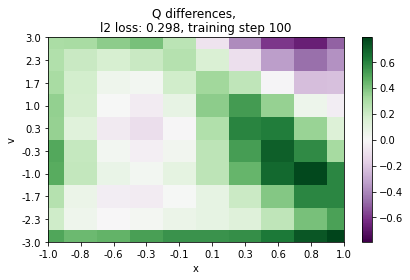

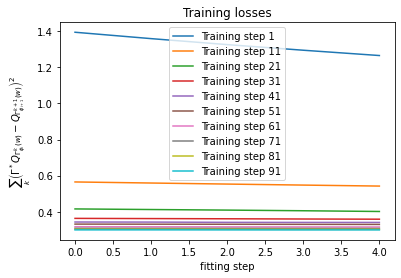

In [19]:
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.weights_collection.dataloader import WeightsDataLoader
from pbo.networks.learnable_pbo import LinearPBO


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
data_loader_weights = WeightsDataLoader(weights_buffer, batch_size_weights, shuffle_key)
pbo = LinearPBO(q_pbo, max_bellman_iterations, True, pbo_network_key, learning_rate)  # add_infinity == True
importance_iteration = jnp.ones(max_bellman_iterations + 1)

l2_losses = np.ones((training_steps, fitting_steps)) * np.nan

for training_step in range(training_steps):
    params_target = pbo.params
    # pbo.reset_optimizer()

    for fitting_step in range(fitting_steps):
        cumulative_l2_loss = 0

        data_loader_weights.shuffle()
        for batch_weights in data_loader_weights:
            data_loader_samples.shuffle()
            for batch_samples in data_loader_samples:
                pbo.params, pbo.optimizer_state, l2_loss = pbo.learn_on_batch(
                    pbo.params, params_target, pbo.optimizer_state, batch_weights, batch_samples, importance_iteration
                )
                cumulative_l2_loss += l2_loss
        
        l2_losses[training_step, fitting_step] = cumulative_l2_loss

    q_weight = validation_initial_weight
    for _ in range(max_bellman_iterations + 100):
        q_weight = pbo(pbo.params, q_weight)
    q_pbo.params = q.to_params(q_weight)
    diff_q_pbo = env.diff_q_mesh(q_pbo, states_x, states_v)

    q_visu_mesh.set_values(diff_q_pbo)
    q_visu_mesh.show(f"Q differences, \nl2 loss: {str(jnp.round(cumulative_l2_loss, 3))}, training step {training_step + 1}", xlabel="x", ylabel="v")


for training_step in range(0, training_steps, 10):
    plt.plot(l2_losses[training_step], label=f"Training step {training_step + 1}")

plt.legend()
plt.xlabel("fitting step")
plt.ylabel(r"$\sum_{k} \left(\Gamma^*Q_{\Gamma_{\phi_i}^k(w)} - Q_{\Gamma_{\phi_{i + 1}}^{k + 1}(w)} \right)^2$")
plt.title("Training losses")
plt.show()

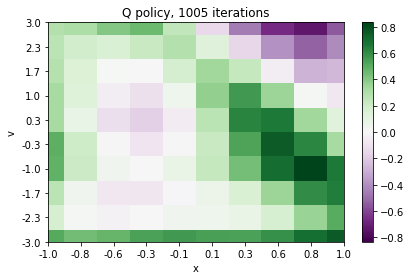

In [20]:
test_bellman_iterations = max_bellman_iterations + 1000

q_weight = validation_initial_weight
for _ in range(test_bellman_iterations):
    q_weight = pbo(pbo.params, q_weight)
q_pbo.params = q_pbo.to_params(q_weight)

q_pbo.params = q_pbo.to_params(pbo.fixed_point(pbo.params))

diff_q_pbo = env.diff_q_mesh(q_pbo, states_x, states_v)

q_visu_mesh = TwoDimesionsMesh(states_x, states_v, sleeping_time=0, axis_equal=False, zero_centered=True)

q_visu_mesh.set_values(diff_q_pbo)
q_visu_mesh.show(f"Q policy, {test_bellman_iterations} iterations", xlabel="x", ylabel="v")

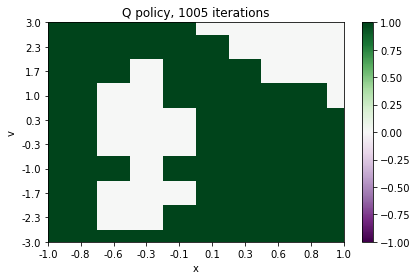

In [21]:
q_visu_mesh.set_values((diff_q_pbo > 0).astype(float))
q_visu_mesh.show(f"Q policy, {test_bellman_iterations} iterations", xlabel="x", ylabel="v")

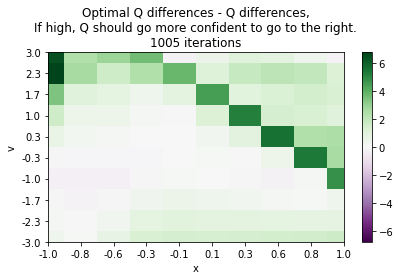

In [22]:
q_visu_mesh.set_values(optimal_diff_q - diff_q_pbo)
q_visu_mesh.show(f"Optimal Q differences - Q differences,\nIf high, Q should go more confident to go to the right.\n{test_bellman_iterations} iterations", xlabel="x", ylabel="v")

In [23]:
q_weight = validation_initial_weight
for _ in range(test_bellman_iterations):
    q_weight = pbo(pbo.params, q_weight)
q_pbo.params = q_pbo.to_params(q_weight)

q_pbo.params = q_pbo.to_params(pbo.fixed_point(pbo.params))


env.simulate(q_pbo, horizon, jnp.array([-0.5, 0]))

[-0.5  0. ]
[0.5662705]
[0.4264123]

[-0.5196691 -0.3866922]
[0.4364527]
[0.41885173]

[-0.57458174 -0.69058496]
[0.3857098]
[0.44903153]

[-0.6150591  -0.11151298]
[0.54026914]
[0.5061749]

[-0.63391644 -0.25889763]
[0.49053442]
[0.5180204]

[-0.6286202   0.36428759]
[0.63537425]
[0.5746244]

[-0.5999781   0.19810008]
[0.62309635]
[0.5272213]

[-0.59043485 -0.01075097]
[0.57290125]
[0.49253184]

[-0.60205024 -0.21727782]
[0.50200504]
[0.48993406]

[-0.6323185  -0.37707025]
[0.45541155]
[0.51430833]

[-0.6386382   0.25126037]
[0.632136]
[0.5688094]

[-0.6200628   0.11366919]
[0.60919684]
[0.53253204]

[-0.61670476 -0.04771309]
[0.5624944]
[0.5120505]

[-0.6292682  -0.19906881]
[0.5103172]
[0.5152865]

[-0.61839825  0.4151988 ]
[0.6326606]
[0.57080626]

[-0.58580637  0.22453456]
[0.6250885]
[0.51947397]

[-0.5751363  -0.01508794]
[0.5702692]
[0.47952402]

[-0.5887138 -0.2514252]
[0.48910737]
[0.47730976]

[-0.62357926 -0.43296173]
[0.4404774]
[0.50497663]

[-0.6358487  0.1888592]
[0.624

DeviceArray([False], dtype=bool)